In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:

import pandas as pd
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)
import numpy as np

In [ ]:
import numpy as np

import matplotlib.pyplot as plt
get_ipython().run_line_magic('matplotlib', 'inline')

import matplotlib.ticker as ticker

import seaborn as sns
sns.set_style('whitegrid')

from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from pandas.plotting import autocorrelation_plot
from sklearn import metrics

import warnings

import datetime
from datetime import timedelta 

In [ ]:
df = pd.read_csv('/home/reenal/teddy/busybee_data.txt', delimiter = "\t")

In [ ]:
df.head()

In [ ]:
df.shape

In [ ]:
df.info()

In [ ]:
df_clean = df.copy()
df_clean.timestamp = df_clean.timestamp.astype('datetime64')
df_clean['date'] = df_clean.timestamp.dt.date
df_clean['dayofweek'] = df_clean.timestamp.dt.dayofweek
df_clean['date_time_halfhour'] = df_clean.timestamp.dt.round('30min')
df_clean['time'] = df_clean.date_time_halfhour.dt.time

In [ ]:
df_clean.groupby('time').size()
# drop duplicates
pre_len = len(df_clean)
df_clean = df_clean.drop_duplicates()

post_len = len(df_clean)

dropped_len = pre_len - post_len
print(dropped_len)

In [ ]:
df.head()

In [ ]:
from statsmodels.tsa.stattools import adfuller
from numpy import log
result = adfuller(df.occupancy.dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

In [ ]:
Since p-value(0.271179) is greater than the significance level(0.05),
let’s difference the series and see how the autocorrelation plot looks like.

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})


# Original Series
fig, axes = plt.subplots(3, 2, sharex=True)
axes[0, 0].plot(df.occupancy); axes[0, 0].set_title('Original Series')
plot_acf(df.occupancy, ax=axes[0, 1])

# 1st Differencing
axes[1, 0].plot(df.occupancy.diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(df.occupancy.diff().dropna(), ax=axes[1, 1])

# 2nd Differencing
axes[2, 0].plot(df.occupancy.diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(df.occupancy.diff().diff().dropna(), ax=axes[2, 1])

plt.show()

In [ ]:
# PACF plot of 1st differenced series
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

fig, axes = plt.subplots(1, 2, sharex=True)
axes[0].plot(df.occupancy.diff()); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,5))
plot_pacf(df.occupancy.diff().dropna(), ax=axes[1])

plt.show()

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

fig, axes = plt.subplots(1, 2, sharex=True)
axes[0].plot(df.occupancy.diff()); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,1.2))
plot_acf(df.occupancy.diff().dropna(), ax=axes[1])

plt.show()

In [ ]:
from statsmodels.tsa.arima_model import ARIMA

# 1,1,2 ARIMA Model
model = ARIMA(df.occupancy, order=(1,1,2))
model_fit = model.fit(disp=0)
print(model_fit.summary())

In [ ]:
# Plot residual errors
residuals = pd.DataFrame(model_fit.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

In [ ]:
# Actual vs Fitted
model_fit.plot_predict(dynamic=False)
plt.show()

In [ ]:

df.drop('id', axis=1, inplace=True)
df.drop('area_id', axis=1, inplace=True)

In [ ]:
df.shape

In [ ]:
from statsmodels.tsa.stattools import acf

# Create Training and Test
train = df.occupancy[:223]
test = df.occupancy[223:]

In [ ]:
# Build Model
# model = ARIMA(train, order=(3,2,1))  
model = ARIMA(train, order=(1,1,2))  
fitted = model.fit(disp=-1)  

# Forecast
fc, se, conf = fitted.forecast(119, alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test.index)
lower_series = pd.Series(conf[:, 0], index=test.index)
upper_series = pd.Series(conf[:, 1], index=test.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [ ]:
# Build Model
model = ARIMA(train, order=(1, 2, 1))  
fitted = model.fit(disp=-1)  
print(fitted.summary())

# Forecast
fc, se, conf = fitted.forecast(119, alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test.index)
lower_series = pd.Series(conf[:, 0], index=test.index)
upper_series = pd.Series(conf[:, 1], index=test.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [ ]:
# Build Model
model = ARIMA(train, order=(1, 1, 1))  
fitted = model.fit(disp=-1)  
print(fitted.summary())

# Forecast
fc, se, conf = fitted.forecast(119, alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test.index)
lower_series = pd.Series(conf[:, 0], index=test.index)
upper_series = pd.Series(conf[:, 1], index=test.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [ ]:
# Build Model
model = ARIMA(train, order=(3, 2, 1))  
fitted = model.fit(disp=-1)  
print(fitted.summary())

# Forecast
fc, se, conf = fitted.forecast(119, alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test.index)
lower_series = pd.Series(conf[:, 0], index=test.index)
upper_series = pd.Series(conf[:, 1], index=test.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [ ]:
# Accuracy metrics
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    acf1 = acf(fc-test)[1]                      # ACF1
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 'acf1':acf1, 
            'corr':corr, 'minmax':minmax})

forecast_accuracy(fc, test.values)

# Exp 2

In [ ]:
df.head()

In [ ]:
df.timestamp = df.timestamp.astype('datetime64')


In [ ]:

df.drop('id', axis=1, inplace=True)
df.drop('area_id', axis=1, inplace=True)

In [ ]:
df.dtypes

In [ ]:
df['occupancy'].unique()

In [ ]:
df['occupancy'] = df['occupancy'].astype(np.int32)

In [ ]:
df['timestamp'] = pd.to_datetime(df['timestamp'], format = '%Y-%m')

In [ ]:
df.dtypes

In [ ]:
# Normal line plot so that we can see data variation
# We can observe that average number of riders is increasing most of the time
# We'll later see decomposed analysis of that curve
df.plot.line(x = 'timestamp', y = 'occupancy')
plt.show()

In [ ]:
to_plot_monthly_variation = df

In [ ]:
# only storing month for each index 
mon = df['timestamp']

# decompose yyyy-mm data-type 
temp= pd.DatetimeIndex(mon)

# assign month part of that data to ```month``` variable
month = pd.Series(temp.month)

# dropping month from to_plot_monthly_variation
to_plot_monthly_variation = to_plot_monthly_variation.drop(['timestamp'], axis = 1)

In [ ]:
# join months so we can get month to average monthly rider mapping
to_plot_monthly_variation = to_plot_monthly_variation.join(month)

In [ ]:
# A quick glance
to_plot_monthly_variation.head()

In [ ]:
# Plotting bar plot for each month
sns.barplot(x = 'timestamp', y = 'occupancy', data = to_plot_monthly_variation)
plt.show()

In [ ]:
to_plot_monthly_variation.plot.scatter(x = 'timestamp', y = 'occupancy')
plt.show()

In [ ]:
rider = df[['occupancy']]

In [ ]:
rider.rolling(6).mean().plot(figsize=(20,10), linewidth=5, fontsize=20)
plt.show()

In [ ]:
rider.diff(periods=4).plot(figsize=(20,10), linewidth=5, fontsize=20)
plt.show()

In [ ]:
pd.plotting.autocorrelation_plot(df['occupancy'])
plt.show()

In [ ]:
pd.plotting.lag_plot(df['occupancy'])
plt.show()

In [ ]:
df = df.set_index('timestamp')

In [ ]:
import statsmodels.api as sm
import seaborn as sns

In [ ]:
# Applying Seasonal ARIMA model to forcast the data 
mod = sm.tsa.SARIMAX(df['occupancy'], trend='n', order=(0,1,0), seasonal_order=(1,1,1,12))
results = mod.fit()
print(results.summary())

In [ ]:
df['forecast'] = results.predict(start = 102, end= 120, dynamic= True)  
df[['occupancy', 'forecast']].plot(figsize=(12, 8))
plt.show()

In [ ]:
def forcasting_future_months(df, no_of_months):
    df_perdict = df.reset_index()
    mon = df_perdict['timestamp']
    mon = mon + pd.DateOffset(months = no_of_months)
    future_dates = mon[-no_of_months -1:]
    df_perdict = df_perdict.set_index('timestamp')
    future = pd.DataFrame(index=future_dates, columns= df_perdict.columns)
    df_perdict = pd.concat([df_perdict, future])
    df_perdict['forecast'] = results.predict(start = 114, end = 125, dynamic= True)  
    df_perdict[['occupancy', 'forecast']].iloc[-no_of_months - 12:].plot(figsize=(12, 8))
    plt.show()
    return df_perdict[-no_of_months:]

In [ ]:
predicted = forcasting_future_months(df,100)

In [ ]:
df = pd.read_json('/home/reenal/busybee/busybee_data2.json')

In [ ]:
import json
# load data using Python JSON module
with open('/home/reenal/busybee/busybee_data2.json','r') as f:
    data = json.loads(f.read())
# Flatten data
df_nested_list = pd.json_normalize(data, record_path =['data'])

In [ ]:
df_nested_list.head()

,occupancy,timestamp
0,0,2022-03-01 00:01:50.056183
1,0,2022-03-01 00:04:20.200283
2,0,2022-03-01 00:04:20.592227
3,0,2022-03-01 00:06:50.701884
4,0,2022-03-01 00:06:51.139851


In [ ]:
(df_nested_list.occupancy < 0).any().any()
print(df_nested_list.where(df_nested_list.occupancy < 0).count())

df_nested_list[df_nested_list.occupancy < 0] = 0

(df_nested_list.occupancy < 0).any().any()

occupancy    1033
timestamp    1033
dtype: int64


False

In [ ]:
df_nested_list["date"]= pd.to_datetime(df_nested_list["timestamp"])

In [ ]:
df_nested_list.drop('timestamp', axis=1, inplace=True)

In [ ]:
df_nested_list.head()

,occupancy,date
0,0,2022-03-01 00:01:50.056183
1,0,2022-03-01 00:04:20.200283
2,0,2022-03-01 00:04:20.592227
3,0,2022-03-01 00:06:50.701884
4,0,2022-03-01 00:06:51.139851


In [ ]:
df_nested_list.describe()

,occupancy
count,35568.000000
mean,50.667426
std,87.702336
min,0.000000
25%,0.000000
50%,14.000000
75%,65.000000
max,1213.000000


In [ ]:
df_nested_list.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35568 entries, 0 to 35567
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   occupancy  35568 non-null  int64         
 1   date       35568 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(1)
memory usage: 555.9 KB


In [ ]:
df_nested_list['year'] = df_nested_list.date.dt.year

In [ ]:
df_nested_list["day"]= df_nested_list.date.dt.day

In [ ]:
df_nested_list["month"]= df_nested_list.date.dt.month

In [ ]:
df_nested_list['dayofweek'] = df_nested_list.date.dt.dayofweek


In [ ]:
df_nested_list['hour'] = df_nested_list.date.dt.hour


In [ ]:
df_nested_list['minute'] = df_nested_list.date.dt.minute

In [ ]:
df_nested_list['second'] = df_nested_list.date.dt.second

In [ ]:
df_nested_list.head()

,occupancy,date,year,day,month,dayofweek,hour,minute,second
0,0,2022-03-01 00:01:50.056183,2022,1,3,1,0,1,50
1,0,2022-03-01 00:04:20.200283,2022,1,3,1,0,4,20
2,0,2022-03-01 00:04:20.592227,2022,1,3,1,0,4,20
3,0,2022-03-01 00:06:50.701884,2022,1,3,1,0,6,50
4,0,2022-03-01 00:06:51.139851,2022,1,3,1,0,6,51


<AxesSubplot:xlabel='year'>

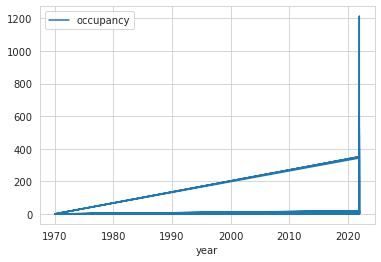

In [ ]:
df_nested_list.plot(x='year', y='occupancy', kind="line")

<AxesSubplot:xlabel='month'>

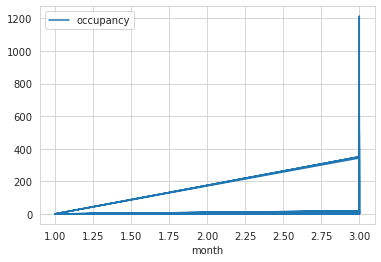

In [ ]:
df_nested_list.plot(x='month', y='occupancy', kind="line")

<AxesSubplot:xlabel='day'>

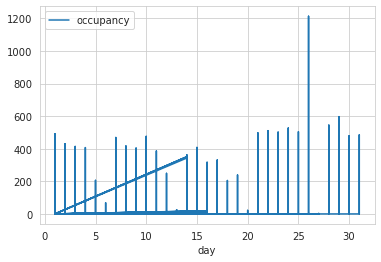

In [ ]:
df_nested_list.plot(x='day', y='occupancy', kind="line")

In [ ]:
test_val = 12
df_train = df_nested_list.iloc[:-test_val]
df_test = df_nested_list.iloc[-test_val:]

In [ ]:
m = Prophet()


NameError: name 'Prophet' is not defined